Te retamos a que encuentres el mejor modelo de clasificación automática de suelos en base a las imágenes proporcionadas por el satélite Sentinel II del servicio Copernicus de la Agencia Espacial Europea.
Variables

Los ficheros contienen un total 55 variables: las 3 primeras de ellas relativas a la identificación de los registros y las 8 últimas variables son distintas referencias geométricas y relativas al entorno (geometría del edificio, métricas geométricas generadas automáticamente -GEOM-, metros cuadrados, año construcción y nº de plantas de los edificios del entorno).

Las imágenes satelitales se han tratado y se ha extraído información de 4 canales (R, G, B y NIR), correspondientes a las bandas de color rojo, verde y azul, y el infrarrojo cercano. El valor mostrado corresponde a la intensidad por deciles en cada imagen. Estas variables empiezan con la letra “Q”.

El fichero "Modelar_UH2020.txt" tiene, adicionalmente como última variable, la clase a predecir.
El ámbito geográfico de las imágenes es una zona concreta del municipio Madrid. La referencia (ID) es distinta y representativa de un elemento diferenciado.

In [ ]:
# Check the versions of libraries

# Python version
import sys
print('Python: {}'.format(sys.version))
# scipy
import scipy
print('scipy: {}'.format(scipy.__version__))
# numpy
import numpy
print('numpy: {}'.format(numpy.__version__))
# matplotlib
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))
# pandas
import pandas
print('pandas: {}'.format(pandas.__version__))
# scikit-learn
import sklearn
print('sklearn: {}'.format(sklearn.__version__))


Python: 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
scipy: 1.4.1
numpy: 1.19.5
matplotlib: 3.2.2
pandas: 1.1.5
sklearn: 1.0.2


In [ ]:
# Cargando las librerías por categoría
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# Generic
import os
import datetime
import itertools
import warnings
warnings.filterwarnings("ignore")

# visualization
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

## scikit modeling libraries
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
                             GradientBoostingClassifier, ExtraTreesClassifier,
                             VotingClassifier)
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import (GridSearchCV, cross_val_score, cross_val_predict,
                                     StratifiedKFold, learning_curve)

## Load metrics for predictive modeling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

#PCA libraries
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
import statsmodels.api as sm

#Label Encoder libraries

from sklearn.preprocessing import LabelEncoder


In [ ]:
import geopandas

In [ ]:
def seleccion_parejas(df):
    parejas=[]
    seleccion_numericas=df.select_dtypes(include="number")
    for i in range(len(df.columns)):
        for j in range(0,i+1):
            parejas.append((df.columns[i],df.columns[j]))
    return parejas

In [ ]:
def correlaciones(df,n=10):
    df=df.select_dtypes(include="number")
    correlacion=df.corr().abs().unstack()
    correlacion=correlacion.drop(labels=seleccion_parejas(df)).sort_values(ascending=False)
    return correlacion[0:n]

In [ ]:
#Carga del archivo de datos a modelar
ruta=("/content/Modelar_UH2020.txt")
df= pd.read_csv(ruta,sep = "|")

In [ ]:
df.tail()

,ID,X,Y,Q_R_4_0_0,Q_R_4_0_1,Q_R_4_0_2,Q_R_4_0_3,Q_R_4_0_4,Q_R_4_0_5,Q_R_4_0_6,Q_R_4_0_7,Q_R_4_0_8,Q_R_4_0_9,Q_R_4_1_0,Q_G_3_0_0,Q_G_3_0_1,Q_G_3_0_2,Q_G_3_0_3,Q_G_3_0_4,Q_G_3_0_5,Q_G_3_0_6,Q_G_3_0_7,Q_G_3_0_8,Q_G_3_0_9,Q_G_3_1_0,Q_B_2_0_0,Q_B_2_0_1,Q_B_2_0_2,Q_B_2_0_3,Q_B_2_0_4,Q_B_2_0_5,Q_B_2_0_6,Q_B_2_0_7,Q_B_2_0_8,Q_B_2_0_9,Q_B_2_1_0,Q_NIR_8_0_0,Q_NIR_8_0_1,Q_NIR_8_0_2,Q_NIR_8_0_3,Q_NIR_8_0_4,Q_NIR_8_0_5,Q_NIR_8_0_6,Q_NIR_8_0_7,Q_NIR_8_0_8,Q_NIR_8_0_9,Q_NIR_8_1_0,AREA,GEOM_R1,GEOM_R2,GEOM_R3,GEOM_R4,CONTRUCTIONYEAR,MAXBUILDINGFLOOR,CADASTRALQUALITYID,CLASE
36395,2D911D5C814985BD,2193374505,165439622,2.751640e-11,397.001868,580.999023,726.002234,854.014478,981.002075,1119.000879,1264.998499,1454.006982,1753.997083,4630.129266,2.994482e-06,363.002579,497.001849,597.001514,682.998462,767.000488,851.998999,948.997882,1076.995190,1296.996497,4844.087215,179.000473,409.999908,452.000000,481.000000,509.000153,536.000061,563.999939,591.999579,625.000000,683.999817,1235.348682,2.170863e-11,696.003888,972.004810,1181.000183,1356.993457,1541.000610,1728.996118,1949.997009,2212.995947,2599.996533,5404.656680,249.244822,0.245849,0.042789,0.023052,0.538739,1955.0,3.0,7,RESIDENTIAL
36396,197A305633E7442D,2186171048,165505005,0.000000e+00,272.000000,415.999481,570.500244,726.998474,886.998840,1048.999268,1218.996521,1424.003052,1737.002991,9109.992397,1.000533e-12,336.999969,423.001434,515.001495,608.999084,698.999817,794.997498,902.005310,1044.999512,1303.499756,8834.396352,34.000290,255.999954,345.999725,426.000214,479.000641,529.000122,563.000000,594.999817,640.000061,736.999573,3336.885843,0.000000e+00,835.004608,1145.005737,1361.003174,1547.003296,1727.995056,1910.996704,2106.995117,2344.991699,2688.000000,9671.928455,384.979852,0.754840,0.027548,0.071174,2.583630,1970.0,6.0,6,RESIDENTIAL
36397,C93FB4F3986C530A,2268944199,165336067,2.875187e-06,558.000000,703.003235,816.000366,907.999023,998.001312,1102.008179,1242.996155,1446.993530,1786.993958,15957.875110,1.840715e-06,486.001129,611.000000,692.999847,763.999878,834.997101,915.001404,1021.000153,1180.001221,1474.500366,16679.452186,173.000671,404.999969,448.000092,482.000000,515.000122,551.999939,594.000122,656.000214,739.000061,867.000000,1497.661511,2.373615e-03,1139.000000,1439.009033,1635.998535,1778.999146,1909.000977,2057.998779,2219.001953,2411.999756,2711.000122,15788.861834,73.154578,0.509862,0.087260,0.079872,0.915335,1988.0,1.0,4,RESIDENTIAL
36398,F0E71EDEB084D8BD,2259339694,165662859,0.000000e+00,487.000378,582.000378,645.000122,703.000891,764.001892,850.001172,1011.005707,1279.001538,1819.001575,6970.479494,2.383909e-07,444.001840,520.998608,571.997394,617.000269,667.997803,750.000012,883.999249,1109.796313,1566.003613,7142.884697,16.000906,309.000064,341.999969,371.000031,400.999579,437.999512,492.000079,587.999982,759.000232,1017.899310,3453.595431,1.648718e-06,1092.998572,1322.001733,1455.999304,1560.998511,1664.996094,1775.002490,1912.999512,2132.789746,2519.890820,6929.965004,110.744190,0.777719,0.057305,0.122549,2.138542,1958.0,1.0,9,RESIDENTIAL
36399,0CFF57D7E8980A03,2198885588,165569047,2.670131e-11,322.999893,485.002716,632.007690,762.000366,888.999451,1024.999146,1179.998535,1371.003418,1667.991699,5938.505929,7.641100e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.shape 

(36400, 56)

In [ ]:
df.size 

2038400

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36400 entries, 0 to 36399
Data columns (total 56 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  36400 non-null  object 
 1   X                   36400 non-null  int64  
 2   Y                   36400 non-null  int64  
 3   Q_R_4_0_0           36400 non-null  float64
 4   Q_R_4_0_1           36400 non-null  float64
 5   Q_R_4_0_2           36400 non-null  float64
 6   Q_R_4_0_3           36400 non-null  float64
 7   Q_R_4_0_4           36400 non-null  float64
 8   Q_R_4_0_5           36400 non-null  float64
 9   Q_R_4_0_6           36400 non-null  float64
 10  Q_R_4_0_7           36400 non-null  float64
 11  Q_R_4_0_8           36400 non-null  float64
 12  Q_R_4_0_9           36400 non-null  float64
 13  Q_R_4_1_0           36400 non-null  float64
 14  Q_G_3_0_0           36400 non-null  float64
 15  Q_G_3_0_1           36399 non-null  float64
 16  Q_G_

In [ ]:
df.describe()

,X,Y,Q_R_4_0_0,Q_R_4_0_1,Q_R_4_0_2,Q_R_4_0_3,Q_R_4_0_4,Q_R_4_0_5,Q_R_4_0_6,Q_R_4_0_7,Q_R_4_0_8,Q_R_4_0_9,Q_R_4_1_0,Q_G_3_0_0,Q_G_3_0_1,Q_G_3_0_2,Q_G_3_0_3,Q_G_3_0_4,Q_G_3_0_5,Q_G_3_0_6,Q_G_3_0_7,Q_G_3_0_8,Q_G_3_0_9,Q_G_3_1_0,Q_B_2_0_0,Q_B_2_0_1,Q_B_2_0_2,Q_B_2_0_3,Q_B_2_0_4,Q_B_2_0_5,Q_B_2_0_6,Q_B_2_0_7,Q_B_2_0_8,Q_B_2_0_9,Q_B_2_1_0,Q_NIR_8_0_0,Q_NIR_8_0_1,Q_NIR_8_0_2,Q_NIR_8_0_3,Q_NIR_8_0_4,Q_NIR_8_0_5,Q_NIR_8_0_6,Q_NIR_8_0_7,Q_NIR_8_0_8,Q_NIR_8_0_9,Q_NIR_8_1_0,AREA,GEOM_R1,GEOM_R2,GEOM_R3,GEOM_R4,CONTRUCTIONYEAR,MAXBUILDINGFLOOR
count,3.640000e+04,3.640000e+04,3.640000e+04,36400.000000,36400.000000,36400.000000,36400.000000,36400.000000,36400.000000,36400.000000,36400.000000,36400.000000,36400.000000,3.640000e+04,36399.000000,36399.000000,36399.000000,36399.000000,36399.000000,36399.000000,36399.000000,36399.000000,36399.000000,36399.000000,36399.000000,36399.000000,36399.000000,36399.000000,36399.000000,36399.000000,36399.000000,36399.000000,36399.000000,36399.000000,36399.000000,3.639900e+04,36399.000000,36399.000000,36399.000000,36399.000000,36399.000000,36399.000000,36399.000000,36399.000000,36399.000000,36399.000000,36399.000000,36399.000000,36399.000000,36399.000000,36399.000000,36399.000000,36392.000000
mean,2.209009e+09,1.655968e+08,3.540339e-05,382.570728,548.497083,683.673632,810.523444,939.255673,1079.239627,1241.824722,1454.005249,1788.890970,7409.247476,1.651995e-03,369.566485,498.410284,596.273880,685.477501,775.091538,873.504796,991.861682,1152.524461,1427.908095,7231.026734,110.024548,372.515704,431.105836,473.218119,510.802801,548.765084,590.584998,640.747689,708.860479,824.962850,2249.891511,5.509070e-01,814.079333,1102.428466,1315.655801,1499.937334,1676.498106,1860.160505,2066.854977,2328.611898,2738.931258,7741.357530,445.727685,0.562705,0.062184,0.061416,1.077118,1972.604137,3.783386
std,2.753816e+07,2.041513e+05,2.027570e-04,99.493837,121.539989,138.030141,153.908319,170.043686,186.912331,207.399421,235.067777,269.413416,3046.724364,2.703061e-01,76.022222,87.202795,96.119883,106.054421,118.358566,134.857237,159.364548,196.327940,246.872314,3029.332927,68.563894,86.691908,84.577753,85.853841,89.241174,94.648381,105.063366,124.886315,154.299364,200.153216,1048.908335,9.468532e+00,228.723116,235.232625,235.485307,236.151640,240.515020,249.037743,265.385253,297.165541,367.532828,2800.581331,1731.933356,0.174176,0.042765,0.040475,0.597814,22.345806,2.969667
min,2.120759e+09,1.650973e+08,0.000000e+00,151.000375,184.999420,214.000473,239.999503,269.999451,310.999493,382.999844,459.001373,591.000671,2497.549557,0.000000e+00,235.007829,274.000061,298.999237,324.999908,364.998383,394.999756,430.000412,485.999817,565.999786,1762.864682,0.000000,84.000022,95.000000,102.000000,110.000031,121.999889,141.000015,182.000060,234.999832,256.999969,539.982317,0.000000e+00,442.997168,700.003967,914.001007,1099.995972,1264.005249,1435.997559,1632.993774,1861.006226,2172.992676,4241.077028,0.108403,0.000626,0.000840,0.000770,0.083703,1820.000000,0.000000
25%,2.194463e+09,1.654526e+08,0.000000e+00,316.997635,492.003845,632.999634,753.999597,875.008087,1006.997498,1173.999329,1378.988965,1691.304590,5745.113586,0.000000e+00,303.999902,440.003516,544.999170,640.998657,724.995758,814.999817,921.001099,1055.001587,1302.499023,5595.960225,54.000381,323.500137,398.000000,451.000061,483.000018,521.000000,551.999878,591.999579,640.000061,715.999817,1578.547045,2.600153e-11,649.703033,950.010461,1151.004639,1336.003833,1513.998901,1692.994263,1878.997437,2126.002441,2474.997534,6051.309064,98.254056,0.454412,0.037979,0.037965,0.803021,1960.000000,1.000000
50%,2.206291e+09,1.655920e+08,0.000000e+00,385.000995,562.997583,698.003998,833.996582,969.999817,1115.001489,1268.997705,1479.002441,1783.003601,6449.615547,1.352518e-11,363.002579,495.997705,597.001514,684.000488,769.000488,864.000793,975.997986,1120.999146,1382.994275,6214.232925,101.000816,396.000089,452.000000,491.999542,524.999756,558.000183,600.000122,632.000531,670.999939,759

Imputación de los Nan

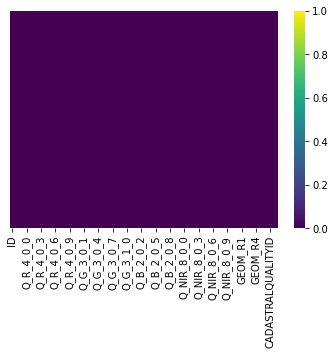

In [ ]:
#A simple vista no se aprecian los Nan
sns.heatmap(df.isnull(),yticklabels=False,cmap="viridis") 

In [ ]:
#Determinación del número de Nan
df.isnull().sum()  

ID                    0
X                     0
Y                     0
Q_R_4_0_0             0
Q_R_4_0_1             0
Q_R_4_0_2             0
Q_R_4_0_3             0
Q_R_4_0_4             0
Q_R_4_0_5             0
Q_R_4_0_6             0
Q_R_4_0_7             0
Q_R_4_0_8             0
Q_R_4_0_9             0
Q_R_4_1_0             0
Q_G_3_0_0             0
Q_G_3_0_1             1
Q_G_3_0_2             1
Q_G_3_0_3             1
Q_G_3_0_4             1
Q_G_3_0_5             1
Q_G_3_0_6             1
Q_G_3_0_7             1
Q_G_3_0_8             1
Q_G_3_0_9             1
Q_G_3_1_0             1
Q_B_2_0_0             1
Q_B_2_0_1             1
Q_B_2_0_2             1
Q_B_2_0_3             1
Q_B_2_0_4             1
Q_B_2_0_5             1
Q_B_2_0_6             1
Q_B_2_0_7             1
Q_B_2_0_8             1
Q_B_2_0_9             1
Q_B_2_1_0             1
Q_NIR_8_0_0           1
Q_NIR_8_0_1           1
Q_NIR_8_0_2           1
Q_NIR_8_0_3           1
Q_NIR_8_0_4           1
Q_NIR_8_0_5     

In [ ]:
#Comprobamos que los Nan correspondadn a la misma fila.
df[df['MAXBUILDINGFLOOR'].isnull()].equals(df[df['CADASTRALQUALITYID'].isnull()]) #Para ver si corresonden a las mismas filas

True

In [ ]:
df[df['MAXBUILDINGFLOOR'].isnull()].groupby(['CLASE'])[['CLASE']].count()

,CLASE
CLASE,
AGRICULTURE,5
INDUSTRIAL,1
RETAIL,1


In [ ]:
#Eliminamos los Nan (ya que constituyen un porcentaje muy bako respecto el total)
df.dropna(inplace=True) 

In [ ]:
#Comprobamos que no quedan Nan
df.isnull().sum() 

ID                    0
X                     0
Y                     0
Q_R_4_0_0             0
Q_R_4_0_1             0
Q_R_4_0_2             0
Q_R_4_0_3             0
Q_R_4_0_4             0
Q_R_4_0_5             0
Q_R_4_0_6             0
Q_R_4_0_7             0
Q_R_4_0_8             0
Q_R_4_0_9             0
Q_R_4_1_0             0
Q_G_3_0_0             0
Q_G_3_0_1             0
Q_G_3_0_2             0
Q_G_3_0_3             0
Q_G_3_0_4             0
Q_G_3_0_5             0
Q_G_3_0_6             0
Q_G_3_0_7             0
Q_G_3_0_8             0
Q_G_3_0_9             0
Q_G_3_1_0             0
Q_B_2_0_0             0
Q_B_2_0_1             0
Q_B_2_0_2             0
Q_B_2_0_3             0
Q_B_2_0_4             0
Q_B_2_0_5             0
Q_B_2_0_6             0
Q_B_2_0_7             0
Q_B_2_0_8             0
Q_B_2_0_9             0
Q_B_2_1_0             0
Q_NIR_8_0_0           0
Q_NIR_8_0_1           0
Q_NIR_8_0_2           0
Q_NIR_8_0_3           0
Q_NIR_8_0_4           0
Q_NIR_8_0_5     

Análisis de la variable dependiente(CLASE)

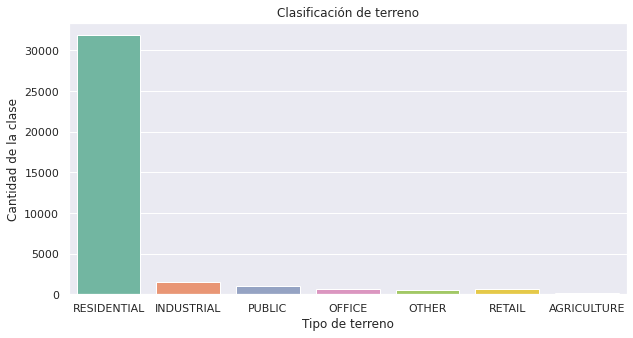

In [ ]:
plt.figure(figsize=(10,5))  #La clase residencial es la mayoritaria
sns.set(style = "darkgrid")
ax = sns.countplot (x ="CLASE" , data = df, palette = "Set2")
plt.title("Clasificación de terreno")
plt.xlabel('Tipo de terreno')
plt.ylabel('Cantidad de la clase')
plt.show()

In [ ]:
print("Clases: ", df['CLASE'].unique())
for c in df['CLASE'].unique():
    print(f"El porcentaje de muestras de tipo {c} es {(sum(df['CLASE']==c) / df.shape[0]):.2f}")

Clases:  ['RESIDENTIAL' 'INDUSTRIAL' 'PUBLIC' 'OFFICE' 'OTHER' 'RETAIL'
 'AGRICULTURE']
El porcentaje de muestras de tipo RESIDENTIAL es 0.88
El porcentaje de muestras de tipo INDUSTRIAL es 0.04
El porcentaje de muestras de tipo PUBLIC es 0.03
El porcentaje de muestras de tipo OFFICE es 0.02
El porcentaje de muestras de tipo OTHER es 0.01
El porcentaje de muestras de tipo RETAIL es 0.02
El porcentaje de muestras de tipo AGRICULTURE es 0.00


In [ ]:
#Comprobamos el número de categorías dentro de la variable 'CLASE'
df.CLASE.unique()

array(['RESIDENTIAL', 'INDUSTRIAL', 'PUBLIC', 'OFFICE', 'OTHER', 'RETAIL',
       'AGRICULTURE'], dtype=object)

In [ ]:
df.CLASE.describe()  #La clase mayoritaria es la Residencial 

count           36392
unique              7
top       RESIDENTIAL
freq            31845
Name: CLASE, dtype: object

In [ ]:
df.CLASE.value_counts()

RESIDENTIAL    31845
INDUSTRIAL      1542
PUBLIC          1072
RETAIL           705
OFFICE           647
OTHER            474
AGRICULTURE      107
Name: CLASE, dtype: int64

Análisis de las variables no relativas a imágenes

In [ ]:
#Variable MAXBUILDINGFLOOR

In [ ]:
df.MAXBUILDINGFLOOR.unique()

array([ 0.,  1.,  8.,  4.,  7.,  2.,  5.,  3., 11.,  9.,  6., 12., 16.,
       10., 25., 13., 14., 22., 15., 17., 24., 19., 23., 18., 21., 20.])

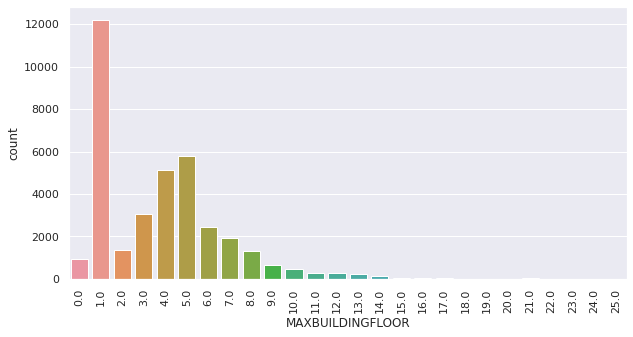

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x='MAXBUILDINGFLOOR', data=df)
x = plt.xticks(rotation=90)

In [ ]:
#Comprobación de inf en el DataFrame
np.isinf(df['MAXBUILDINGFLOOR']).values.sum()

0

In [ ]:
#Variable CADASTRALQUALITYID

In [ ]:
df.CADASTRALQUALITYID.unique()  #Observamos etiquetas numéricas y alfabéticas

array(['2', '8', '5', '6', '4', '7', '3', 'C', '1', '9', 'B', 'A'],
      dtype=object)

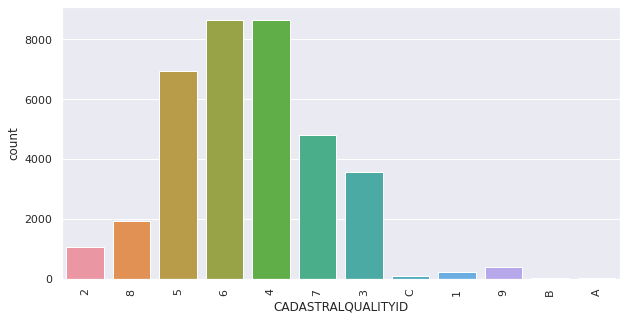

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x='CADASTRALQUALITYID', data=df)
x = plt.xticks(rotation=90)

In [ ]:
#Codificamos las variables numéricas CADASTRALQUALITYID y CLASE en valores numéricos
number = LabelEncoder()

In [ ]:
df['CADASTRALQUALITYID'] = number.fit_transform(df['CADASTRALQUALITYID'].astype(str))

In [ ]:
number_2 = LabelEncoder()

In [ ]:
df['CLASE'] = number_2.fit_transform(df['CLASE'].astype(str))

In [ ]:
#Variable CONTRUCTIONYEAR

In [ ]:
df.CONTRUCTIONYEAR.unique()

array([2002., 1949., 1986., 1999., 1966., 1992., 1982., 1952., 1970.,
       1990., 1950., 2003., 1972., 1955., 1960., 1984., 2000., 1969.,
       1973., 1956., 2016., 1974., 1957., 1968., 1976., 2005., 1962.,
       1961., 2004., 1980., 1965., 1946., 1978., 1920., 2010., 1991.,
       1997., 1979., 1988., 1959., 1964., 2006., 2014., 1993., 2012.,
       1998., 1983., 1975., 1994., 1930., 1941., 2001., 1954., 1963.,
       1923., 1958., 1987., 1981., 1971., 1989., 1905., 2015., 1951.,
       1977., 1940., 1996., 1953., 1934., 2007., 1935., 1927., 1900.,
       1995., 1948., 2011., 1985., 1967., 2008., 2013., 1925., 1942.,
       1922., 1945., 1947., 2009., 1944., 1910., 1887., 1915., 1928.,
       1929., 1924., 1931., 1943., 1916., 1918., 1938., 1890., 1939.,
       1936., 1908., 1898., 1926., 1932., 1880., 1903., 1933., 1937.,
       1820., 2017., 1902., 1921., 1912., 1917., 1906., 1914., 1860.,
       1892., 1884., 1919., 1894., 1911., 1885., 1904., 1907., 1913.,
       1850., 1909.,

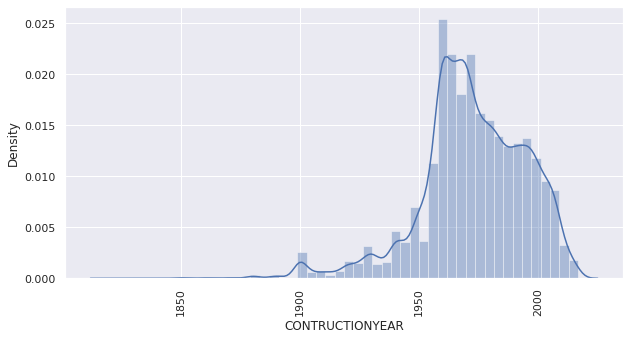

In [ ]:
#Distribución asimétrica a la derecha (edificios nuevos)
plt.figure(figsize=(10,5))
sns.distplot(df.CONTRUCTIONYEAR)
x = plt.xticks(rotation=90)

Análisis de las variables de localización (X e Y)

In [ ]:
pip install geopandas

     |████████████████████████████████| 1.0 MB 4.0 MB/s 
     |████████████████████████████████| 6.3 MB 19.0 MB/s 
     |████████████████████████████████| 15.4 MB 38 kB/s 


In [ ]:
#Creamos un DataFrame con las coordenadas
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.X, df.Y))

In [ ]:
gdf.head() #Se ha creado la columna de geometry

,ID,X,Y,Q_R_4_0_0,Q_R_4_0_1,Q_R_4_0_2,Q_R_4_0_3,Q_R_4_0_4,Q_R_4_0_5,Q_R_4_0_6,Q_R_4_0_7,Q_R_4_0_8,Q_R_4_0_9,Q_R_4_1_0,Q_G_3_0_0,Q_G_3_0_1,Q_G_3_0_2,Q_G_3_0_3,Q_G_3_0_4,Q_G_3_0_5,Q_G_3_0_6,Q_G_3_0_7,Q_G_3_0_8,Q_G_3_0_9,Q_G_3_1_0,Q_B_2_0_0,Q_B_2_0_1,Q_B_2_0_2,Q_B_2_0_3,Q_B_2_0_4,Q_B_2_0_5,Q_B_2_0_6,Q_B_2_0_7,Q_B_2_0_8,Q_B_2_0_9,Q_B_2_1_0,Q_NIR_8_0_0,Q_NIR_8_0_1,Q_NIR_8_0_2,Q_NIR_8_0_3,Q_NIR_8_0_4,Q_NIR_8_0_5,Q_NIR_8_0_6,Q_NIR_8_0_7,Q_NIR_8_0_8,Q_NIR_8_0_9,Q_NIR_8_1_0,AREA,GEOM_R1,GEOM_R2,GEOM_R3,GEOM_R4,CONTRUCTIONYEAR,MAXBUILDINGFLOOR,CADASTRALQUALITYID,geometry
0,44198C2A811A4DF4,2200905624,165480229,0.000001,445.999637,634.001172,780.000568,902.004053,1025.997009,1157.997681,1304.999585,1501.002661,1830.998926,7098.504905,0.000002,383.999710,528.000317,633.998871,724.998218,811.000366,901.999060,1010.996002,1162.000439,1438.003833,6630.661924,147.000473,461.000000,493.000122,522.999878,550.000061,575.999939,604.999817,647.000122,707.000122,825.000891,2962.301546,1.063087e-05,631.998126,889.002136,1084.999243,1259.988721,1432.501221,1619.998560,1835.995764,2120.993359,2545.997754,6803.875107,283.593030,0.046741,0.014588,0.011298,0.774503,1994,5.0,4,POINT (2200905624.000 165480229.000)
1,216F638609E0E39E,2207436564,165625751,0.000000,385.000995,580.005762,737.004449,873.996460,1005.998779,1141.001758,1296.997083,1505.996753,1822.994031,5364.803157,0.000000,346.996735,495.997705,602.000580,701.000647,795.999268,889.995288,995.997449,1138.001709,1387.002820,5534.496367,99.000961,483.999969,521.000342,547.000183,570.000061,591.999878,615.798437,643.000183,682.000122,754.700116,2182.966982,7.401012e-12,558.004102,809.008313,1002.009210,1175.000195,1327.996887,1486.795728,1666.104956,1884.994067,2220.990137,5544.670485,357.712450,0.378483,0.041085,0.025753,0.626835,1968,8.0,3,POINT (2207436564.000 165625751.000)
2,FFFCEFB11E257364,2200313961,165752898,0.000000,343.996613,567.010620,745.995483,900.997925,1051.995361,1200.006226,1370.990234,1590.001099,1905.991516,7074.674140,0.000000,291.003632,458.000061,579.999023,685.998840,780.000336,878.996094,992.996582,1149.010254,1425.496948,8340.301104,214.000305,472.000015,508.000153,539.000061,567.999878,591.000000,614.999695,638.999847,670.999939,722.999695,1542.247090,0.000000e+00,489.004868,776.002319,992.004883,1186.992432,1364.991089,1551.001343,1759.008057,2022.004272,2421.002441,8827.104856,160.979017,0.306545,0.034637,0.054977,1.587207,1968,5.0,7,POINT (2200313961.000 165752898.000)
3,596C5C8CE10BCF,2199220382,166288192,0.000000,173.999956,218.000000,261.999713,315.999951,408.000565,560.000500,700.697351,863.000671,1200.897534,7689.470151,0.000006,251.000169,291.999847,328.000739,369.998914,434.998367,545.000671,664.699524,792.998560,1068.003235,7690.967231,3.000620,130.999969,151.000061,175.999939,206.000137,242.000015,318.000031,367.999969,457.000299,691.000049,1713.185116,5.006439e+00,1307.006531,1527.999072,1675.999512,1798.999854,1924.994751,2054.998730,2212.999951,2422.002002,2752.005786,7734.759269,9088.678448,0.338955,0.006846,0.005448,0.795725,1993,6.0,6,POINT (2199220382.000 166288192.000)
4,F931B9FA2A8641D1,2209143550,165253334,0.000007,588.002014,738.999451,848.001282,954.000244,1074.000183,1228.998291,1416.999817,1639.999268,1937.999329,7535.480762,0.000013,513.999084,645.999207,739.015839,831.997925,931.005920,1050.008301,1203.999451,1395.999023,1677.999146,7280.822226,47.000126,398.000137,462.999939,512.006744,571.000061,633.000397,706.000061,796.000000,910.001160,1102.999512,2955.738621,2.748954e-04,1103.002808,1350.003296,1535.006531,1692.002075,1839.000488,1996.000000,2159.998657,2366.000000,2712.997681,7435.991490,994.424368,0.581476,0.036470,0.016033,0.439638,1964,4.0,7,POINT (2209143550.000 165253334.000)


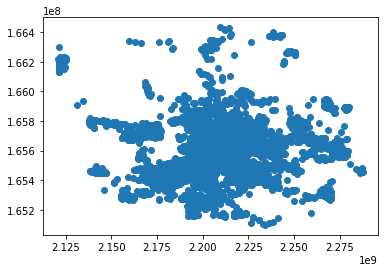

In [ ]:
#Las variables X e Y pueden corresponder a lat y lon.
plt.scatter(x=df['X'], y=df['Y'])
plt.show()

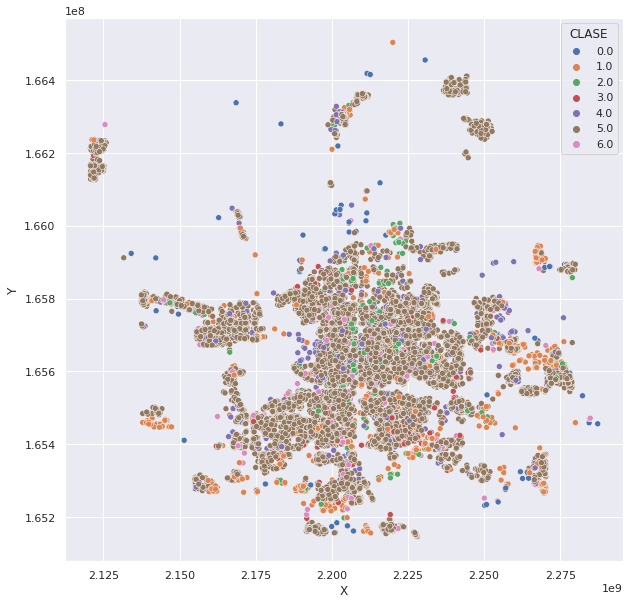

In [ ]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x='X', y='Y', data=df_2, hue= df_2.CLASE);

Correlación de variables

In [ ]:
df.corr ("pearson") #Para poder interpretar mejor los datos hemos creado funciones (vara ver cuales son las variables más correlacionadas)

,X,Y,Q_R_4_0_0,Q_R_4_0_1,Q_R_4_0_2,Q_R_4_0_3,Q_R_4_0_4,Q_R_4_0_5,Q_R_4_0_6,Q_R_4_0_7,Q_R_4_0_8,Q_R_4_0_9,Q_R_4_1_0,Q_G_3_0_0,Q_G_3_0_1,Q_G_3_0_2,Q_G_3_0_3,Q_G_3_0_4,Q_G_3_0_5,Q_G_3_0_6,Q_G_3_0_7,Q_G_3_0_8,Q_G_3_0_9,Q_G_3_1_0,Q_B_2_0_0,Q_B_2_0_1,Q_B_2_0_2,Q_B_2_0_3,Q_B_2_0_4,Q_B_2_0_5,Q_B_2_0_6,Q_B_2_0_7,Q_B_2_0_8,Q_B_2_0_9,Q_B_2_1_0,Q_NIR_8_0_0,Q_NIR_8_0_1,Q_NIR_8_0_2,Q_NIR_8_0_3,Q_NIR_8_0_4,Q_NIR_8_0_5,Q_NIR_8_0_6,Q_NIR_8_0_7,Q_NIR_8_0_8,Q_NIR_8_0_9,Q_NIR_8_1_0,AREA,GEOM_R1,GEOM_R2,GEOM_R3,GEOM_R4,CONTRUCTIONYEAR,MAXBUILDINGFLOOR,CADASTRALQUALITYID,CLASE
X,1.000000,0.005750,0.067438,0.426442,0.451926,0.445450,0.431606,0.428603,0.431265,0.434269,0.438699,0.441880,0.115864,-0.005903,0.326324,0.425052,0.452169,0.459867,0.463891,0.463394,0.457975,0.463633,0.458583,0.121831,0.169273,0.344231,0.384759,0.429287,0.459430,0.473086,0.470238,0.459605,0.441087,0.402264,0.001319,-0.019338,-0.006483,-0.006798,-0.004980,0.008803,0.032932,0.060143,0.088115,0.109952,0.128492,0.108597,0.027037,-0.048132,-0.021093,-0.008347,0.003983,0.070408,0.016267,0.056778,-0.058923
Y,0.005750,1.000000,-0.198921,-0.482935,-0.503490,-0.503799,-0.497365,-0.489579,-0.476618,-0.451743,-0.416504,-0.376307,-0.120599,0.017938,-0.493197,-0.524453,-0.516699,-0.494282,-0.458265,-0.419836,-0.379389,-0.331291,-0.300258,-0.093754,-0.113362,-0.341353,-0.410745,-0.429068,-0.421663,-0.406029,-0.375915,-0.340983,-0.313243,-0.308267,-0.257316,0.174918,0.082974,0.076080,0.065593,0.057705,0.045452,0.025804,-0.003048,-0.036079,-0.068607,-0.018996,0.002428,-0.050163,-0.018852,-0.036196,-0.014949,0.134550,-0.137609,-0.238330,0.032330
Q_R_4_0_0,0.067438,-0.198921,1.000000,0.207799,0.120315,0.089789,0.078376,0.069915,0.063222,0.051400,0.032770,0.007038,-0.049336,0.006108,0.326203,0.281859,0.224900,0.186386,0.146438,0.126534,0.113139,0.089778,0.064220,-0.051691,-0.004167,-0.053925,-0.032501,0.002392,0.024529,0.048798,0.068508,0.076813,0.079276,0.083232,0.029353,0.011803,0.295434,0.278421,0.271205,0.266500,0.261332,0.258209,0.267433,0.313283,0.413193,-0.062628,-0.015062,0.029339,0.052531,0.074370,0.010951,0.094885,-0.113826,-0.021250,-0.053996
Q_R_4_0_1,0.426442,-0.482935,0.207799,1.000000,0.954741,0.893924,0.840248,0.795863,0.757104,0.719163,0.674682,0.623513,0.067729,-0.000391,0.908429,0.942593,0.913624,0.871509,0.825370,0.776350,0.724997,0.672944,0.620474,0.111744,0.379820,0.640181,0.633075,0.644300,0.654229,0.660542,0.658719,0.641321,0.624048,0.603974,0.225245,-0.072831,0.213728,0.203424,0.189524,0.179931,0.176758,0.178200,0.186614,0.188388,0.173337,0.055793,0.028841,0.017372,0.016416,0.028892,0.017578,0.026339,-0.038401,0.117866,-0.116751
Q_R_4_0_2,0.451926,-0.503490,0.120315,0.954741,1.000000,0.983834,0.953446,0.920808,0.887145,0.850150,0.802496,0.742007,0.101646,-0.003795,0.810746,0.928093,0.949877,0.935516,0.901421,0.854390,0.799371,0.740770,0.684009,0.149427,0.401645,0.785677,0.801545,0.808809,0.808247,0.793552,0.765046,0.718610,0.670797,0.622882,0.251839,-0.111028,0.007145,0.013887,0.015454,0.021887,0.034365,0.051755,0.074385,0.087655,0.077638,0.083223,0.027850,0.015792,-0.002272,0.009735,0.016233,-0.033598,0.046116,0.162134,-0.085680
Q_R_4_0_3,0.445450,-0.503799,0.089789,0.893924,0.983834,1.000000,0.990979,0.971620,0.945865,0.912363,0.864627,0.800015,0.137914,-0.006532,0.733856,0.886855,0.938439,0.945226,0.923532,0.882222,0.828073,0.767494,0.709304,0.184644,0.391964,0.827960,0.867434,0.880909,0.880263,0.859037,0.818059,0.756086,0.691211,0.628112,0.268300,-0.133645,-0.110694,-0.094315,-0.084045,-0.068009,-0.045771,-0.018878,0.012002,0.033273,0.030079,0.113040,0.029125,0.015253,-0.019335,-0.005837,0.017311,-0.080833,0.100679,0.184422,-0.070224
Q_R_4_0_4,0.431606,-0.497365,0.078376,0.840248,0.953446,0.990979,1.000000,0.993516,0.976392,0.947890,0.902089,0.836247,0.173630,-0.008761,0.680857,0.849735,0.919563,0.942183,0.932080,0.898112,0.847153,0.786781,0.727597,0.216123,0.370132,0.831046,0.889550,0.912054,0.916169,0.897169,0.852612,0.783148,0.708639,0.636148,0.286331,-0.147799,-

In [ ]:
seleccion_parejas(df)

[('ID', 'ID'),
 ('X', 'ID'),
 ('X', 'X'),
 ('Y', 'ID'),
 ('Y', 'X'),
 ('Y', 'Y'),
 ('Q_R_4_0_0', 'ID'),
 ('Q_R_4_0_0', 'X'),
 ('Q_R_4_0_0', 'Y'),
 ('Q_R_4_0_0', 'Q_R_4_0_0'),
 ('Q_R_4_0_1', 'ID'),
 ('Q_R_4_0_1', 'X'),
 ('Q_R_4_0_1', 'Y'),
 ('Q_R_4_0_1', 'Q_R_4_0_0'),
 ('Q_R_4_0_1', 'Q_R_4_0_1'),
 ('Q_R_4_0_2', 'ID'),
 ('Q_R_4_0_2', 'X'),
 ('Q_R_4_0_2', 'Y'),
 ('Q_R_4_0_2', 'Q_R_4_0_0'),
 ('Q_R_4_0_2', 'Q_R_4_0_1'),
 ('Q_R_4_0_2', 'Q_R_4_0_2'),
 ('Q_R_4_0_3', 'ID'),
 ('Q_R_4_0_3', 'X'),
 ('Q_R_4_0_3', 'Y'),
 ('Q_R_4_0_3', 'Q_R_4_0_0'),
 ('Q_R_4_0_3', 'Q_R_4_0_1'),
 ('Q_R_4_0_3', 'Q_R_4_0_2'),
 ('Q_R_4_0_3', 'Q_R_4_0_3'),
 ('Q_R_4_0_4', 'ID'),
 ('Q_R_4_0_4', 'X'),
 ('Q_R_4_0_4', 'Y'),
 ('Q_R_4_0_4', 'Q_R_4_0_0'),
 ('Q_R_4_0_4', 'Q_R_4_0_1'),
 ('Q_R_4_0_4', 'Q_R_4_0_2'),
 ('Q_R_4_0_4', 'Q_R_4_0_3'),
 ('Q_R_4_0_4', 'Q_R_4_0_4'),
 ('Q_R_4_0_5', 'ID'),
 ('Q_R_4_0_5', 'X'),
 ('Q_R_4_0_5', 'Y'),
 ('Q_R_4_0_5', 'Q_R_4_0_0'),
 ('Q_R_4_0_5', 'Q_R_4_0_1'),
 ('Q_R_4_0_5', 'Q_R_4_0_2'),
 ('Q_R_4_0_5

In [ ]:
def correlaciones(df,n=10):
    df=df.select_dtypes(include="number")
    correlacion=df.corr().abs().unstack()
    correlacion=correlacion.drop(labels=seleccion_parejas(df)).sort_values(ascending=False)
    return correlacion[0:n]

In [ ]:
correlaciones(df) #Gran cantidad de variables con una alta correlación

Q_NIR_8_0_4  Q_NIR_8_0_5    0.993925
Q_R_4_0_5    Q_R_4_0_6      0.993891
Q_NIR_8_0_3  Q_NIR_8_0_4    0.993611
Q_R_4_0_4    Q_R_4_0_5      0.993516
Q_NIR_8_0_5  Q_NIR_8_0_6    0.993277
Q_NIR_8_0_6  Q_NIR_8_0_7    0.992850
Q_R_4_0_6    Q_R_4_0_7      0.992102
Q_NIR_8_0_2  Q_NIR_8_0_3    0.991925
Q_G_3_0_5    Q_G_3_0_6      0.991514
Q_G_3_0_4    Q_G_3_0_5      0.991446
dtype: float64

In [ ]:
#Guardamos los datos tratados en foramto pickle para su posterior modelado
df.to_pickle("/content/Modelar_EDA.pkl") 

Análisis de Componenetes Princiopales (PCA)

In [ ]:
df_pca = df.drop (['ID','X','Y','GEOM_R1','GEOM_R2','GEOM_R3','GEOM_R4'], axis= 1)

In [ ]:
df_pca.mean(axis=0)

Q_R_4_0_0                0.000035
Q_R_4_0_1              382.525377
Q_R_4_0_2              548.455425
Q_R_4_0_3              683.636711
Q_R_4_0_4              810.491695
Q_R_4_0_5              939.228828
Q_R_4_0_6             1079.218219
Q_R_4_0_7             1241.809296
Q_R_4_0_8             1453.996539
Q_R_4_0_9             1788.880944
Q_R_4_1_0             7409.598131
Q_G_3_0_0                0.001442
Q_G_3_0_1              369.527245
Q_G_3_0_2              498.373046
Q_G_3_0_3              596.239502
Q_G_3_0_4              685.445745
Q_G_3_0_5              775.061549
Q_G_3_0_6              873.476481
Q_G_3_0_7              991.834588
Q_G_3_0_8             1152.497561
Q_G_3_0_9             1427.875790
Q_G_3_1_0             7231.328576
Q_B_2_0_0              110.027163
Q_B_2_0_1              372.508577
Q_B_2_0_2              431.098630
Q_B_2_0_3              473.209615
Q_B_2_0_4              510.793613
Q_B_2_0_5              548.755531
Q_B_2_0_6              590.575438
Q_B_2_0_7     

In [ ]:
df_pca.var(axis=0)

Q_R_4_0_0             4.110192e-08
Q_R_4_0_1             9.889501e+03
Q_R_4_0_2             1.476523e+04
Q_R_4_0_3             1.904873e+04
Q_R_4_0_4             2.368722e+04
Q_R_4_0_5             2.891696e+04
Q_R_4_0_6             3.494096e+04
Q_R_4_0_7             4.302207e+04
Q_R_4_0_8             5.526760e+04
Q_R_4_0_9             7.259740e+04
Q_R_4_1_0             9.283857e+06
Q_G_3_0_0             7.147770e-02
Q_G_3_0_1             5.772479e+03
Q_G_3_0_2             7.598569e+03
Q_G_3_0_3             9.234601e+03
Q_G_3_0_4             1.124430e+04
Q_G_3_0_5             1.400641e+04
Q_G_3_0_6             1.818512e+04
Q_G_3_0_7             2.539705e+04
Q_G_3_0_8             3.854705e+04
Q_G_3_0_9             6.095086e+04
Q_G_3_1_0             9.178047e+06
Q_B_2_0_0             4.701769e+03
Q_B_2_0_1             7.516544e+03
Q_B_2_0_2             7.154369e+03
Q_B_2_0_3             7.371720e+03
Q_B_2_0_4             7.964828e+03
Q_B_2_0_5             8.959272e+03
Q_B_2_0_6           

In [ ]:
# Entrenamiento modelo PCA con escalado de los datos mediante el uso de pipeline

pca_pipe = make_pipeline(StandardScaler(), PCA())
pca_pipe.fit(df_pca)

# Se extrae el modelo entrenado del pipeline
modelo_pca = pca_pipe.named_steps['pca']

In [ ]:
#valor de los loadings ϕ que definen cada componente (eigenvector)
modelo_pca.components_

array([[ 2.41790425e-02,  1.71928257e-01,  1.90142881e-01, ...,
         2.16632890e-02,  4.09602829e-02, -2.61349624e-02],
       [ 9.89643021e-02,  4.06266411e-02, -1.20511704e-02, ...,
        -1.14504941e-01, -2.91008803e-02, -4.30307607e-02],
       [-7.53004411e-02, -1.21641717e-01, -1.06200558e-01, ...,
         2.32893118e-02,  7.39751277e-03, -3.35062509e-02],
       ...,
       [-1.33189260e-03,  3.72332653e-02, -1.06685647e-01, ...,
        -9.09654495e-05, -8.39256708e-04,  1.00135133e-05],
       [-2.26138952e-03,  8.35073278e-03, -2.61177668e-02, ...,
        -2.25507109e-04,  1.30492827e-03,  1.53069177e-04],
       [-9.82837192e-04, -1.46648008e-02,  7.29578250e-02, ...,
        -2.22395835e-04,  1.22655083e-04,  2.11530684e-04]])

In [ ]:
# Se combierte el array a dataframe para añadir nombres a los ejes.
pd.DataFrame(
    data    = modelo_pca.components_,
    columns = df_pca.columns,
    index   = ['PC0','PC1', 'PC2', 'PC3','PC4', 'PC5', 'PC6','PC7', 'PC8', 'PC9','PC9', 'PC11', 'PC12','PC13', 'PC14', 'PC15','PC16', 'PC17', 'PC18','PC19', 'PC20', 
                'PC21', 'PC22', 'PC23','PC24', 'PC25', 'PC26','PC27', 'PC28', 'PC29','PC30', 'PC31', 'PC32','PC33', 'PC34', 'PC35','P316', 'PC37', 'PC38','PC39', 'PC40',
               'PC41', 'PC42', 'PC43','PC44', 'PC45', 'PC46','PC47', 'PC48'])

,Q_R_4_0_0,Q_R_4_0_1,Q_R_4_0_2,Q_R_4_0_3,Q_R_4_0_4,Q_R_4_0_5,Q_R_4_0_6,Q_R_4_0_7,Q_R_4_0_8,Q_R_4_0_9,Q_R_4_1_0,Q_G_3_0_0,Q_G_3_0_1,Q_G_3_0_2,Q_G_3_0_3,Q_G_3_0_4,Q_G_3_0_5,Q_G_3_0_6,Q_G_3_0_7,Q_G_3_0_8,Q_G_3_0_9,Q_G_3_1_0,Q_B_2_0_0,Q_B_2_0_1,Q_B_2_0_2,Q_B_2_0_3,Q_B_2_0_4,Q_B_2_0_5,Q_B_2_0_6,Q_B_2_0_7,Q_B_2_0_8,Q_B_2_0_9,Q_B_2_1_0,Q_NIR_8_0_0,Q_NIR_8_0_1,Q_NIR_8_0_2,Q_NIR_8_0_3,Q_NIR_8_0_4,Q_NIR_8_0_5,Q_NIR_8_0_6,Q_NIR_8_0_7,Q_NIR_8_0_8,Q_NIR_8_0_9,Q_NIR_8_1_0,AREA,CONTRUCTIONYEAR,MAXBUILDINGFLOOR,CADASTRALQUALITYID,CLASE
PC0,0.024179,0.171928,0.190143,0.196190,0.198666,0.200641,0.202073,0.202564,0.200446,0.194227,0.039283,-0.002411,0.152300,0.183560,0.196929,0.203462,0.206048,0.205277,0.201241,0.194401,0.185201,0.045904,0.056909,0.151706,0.170163,0.181734,0.190636,0.197621,0.198535,0.192229,0.182104,0.169431,0.073106,-0.032908,-0.008751,-0.001468,0.003944,0.010286,0.017635,0.025785,0.034238,0.040232,0.039496,0.031496,0.012429,-0.003350,0.021663,0.040960,-0.026135
PC1,0.098964,0.040627,-0.012051,-0.040824,-0.054477,-0.056484,-0.052025,-0.041921,-0.028615,-0.010065,-0.041869,0.008480,0.141042,0.087916,0.054290,0.036730,0.033348,0.039383,0.050128,0.058628,0.062342,-0.052043,-0.135640,-0.167251,-0.154085,-0.130612,-0.101517,-0.062133,-0.019954,0.019787,0.054558,0.083510,-0.003772,0.034914,0.286997,0.299127,0.304565,0.306169,0.304992,0.300619,0.293468,0.283125,0.264594,-0.040677,0.007132,0.131886,-0.114505,-0.029101,-0.043031
PC2,-0.075300,-0.121642,-0.106201,-0.079905,-0.050588,-0.022685,0.005291,0.030373,0.054657,0.077698,0.505398,-0.009836,-0.098168,-0.099972,-0.080245,-0.053616,-0.024750,0.002026,0.023774,0.049645,0.071385,0.497408,-0.238812,-0.108279,-0.067676,-0.046692,-0.024398,0.008497,0.036120,0.059968,0.078241,0.087736,0.254704,-0.035640,-0.006985,0.004691,0.009942,0.013835,0.013853,0.013988,0.011558,0.012372,0.006582,0.491866,0.028096,-0.040349,0.023289,0.007398,-0.033506
PC3,0.176316,0.269907,0.208700,0.158957,0.117793,0.070462,0.018425,-0.041492,-0.108272,-0.178924,0.204595,0.026295,0.248146,0.203662,0.144435,0.083143,0.014818,-0.054107,-0.120254,-0.180898,-0.231412,0.243870,0.212913,0.154894,0.081764,0.027091,-0.028444,-0.090885,-0.151809,-0.203129,-0.231429,-0.235950,-0.038012,0.061620,0.104869,0.081706,0.059730,0.038973,0.017599,-0.001629,-0.016016,-0.019224,-0.002778,0.256025,-0.121198,-0.083706,-0.164540,-0.001054,0.152473
PC4,0.000861,0.062087,0.034953,0.020889,0.012083,0.004911,-0.001852,-0.009870,-0.019012,-0.027054,-0.004516,0.445231,0.053221,0.024426,0.010506,0.000617,-0.005487,-0.010872,-0.015528,-0.019054,-0.018235,-0.000527,0.009272,-0.020169,-0.030639,-0.034971,-0.034774,-0.031240,-0.023234,-0.010000,0.007152,0.020376,0.034740,0.498007,0.064908,0.042009,0.026087,0.011236,-0.001860,-0.014360,-0.026334,-0.039726,-0.058882,-0.003590,0.299596,-0.275475,0.231162,0.342829,-0.430957
PC5,-0.076891,0.139793,0.079975,0.031896,-0.006713,-0.029673,-0.038978,-0.036796,-0.023424,-0.004087,0.041507,0.110861,0.058521,0.018657,-0.010013,-0.024635,-0.028576,-0.022804,-0.008170,0.023731,0.053907,0.036975,0.122054,0.035631,-0.031698,-0.054523,-0.058683,-0.042868,-0.003259,0.043543,0.088103,0.113982,0.051575,0.168232,0.137611,0.078661,0.028389,-0.017553,-0.062840,-0.106755,-0.145895,-0.184604,-0.215029,0.015990,0.200621,0.495476,-0.115829,-0.593573,-0.253093
PC6,-0.152046,-0.081945,-0.043152,-0.023882,-0.011750,0.000994,0.012712,0.026522,0.043445,0.052533,-0.010474,0.517510,-0.084687,-0.057888,-0.035587,-0.017031,0.002435,0.018888,0.034082,0.049434,0.054246,-0.020460,-0.037448,0.008339,0.018634,0.024208,0.030337,0.038153,0.042908,0.044257,0.038682,0.030212,-0.006511,0.410036,-0.018049,-0.012855,-0.007868,-0.001647,0.005077,0.010359,0.011753,0.004520,-0.014125,-0.006967,-0.543274,0.058198,-0.258319,-0.050161,0.355966
PC7,0.153949,-0.142862,-0.074411,-0.027557,0.006737,0.023890,0.028934,0.024806,0.009564,-0.017495,0.031607,0.300378,-0.114896,-0.028345,0.015904,0.039845,0.042234,0.033628,0.013264,-0.024079,-0.074178,0.050730,0.00

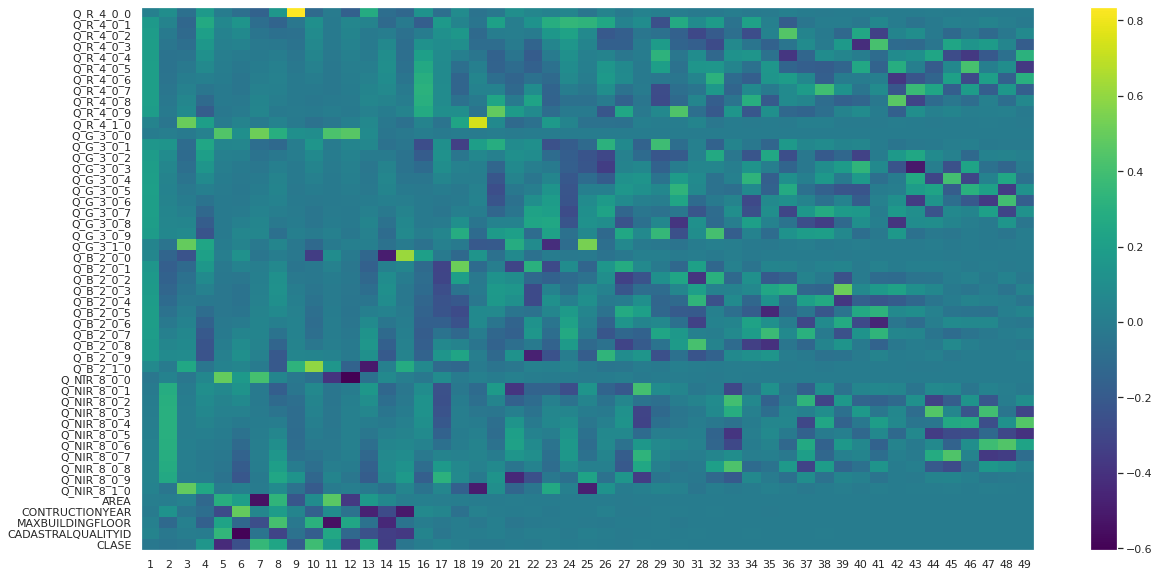

In [ ]:
# Heatmap componentes (influencia de las variables en cada componente)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
componentes = modelo_pca.components_
plt.imshow(componentes.T, cmap='viridis', aspect='auto')
plt.yticks(range(len(df_pca.columns)), df_pca.columns)
plt.xticks(range(len(df_pca.columns)), np.arange(modelo_pca.n_components_) + 1)
plt.grid(False)
plt.colorbar();

----------------------------------------------------
Porcentaje de varianza explicada por cada componente
----------------------------------------------------
[4.67529120e-01 2.11289540e-01 6.22164842e-02 4.33638356e-02
 2.68234688e-02 2.51913789e-02 2.33814054e-02 2.15508430e-02
 1.87174486e-02 1.61607588e-02 1.52164076e-02 1.49421188e-02
 1.37650416e-02 1.11752578e-02 1.01459125e-02 4.10492355e-03
 3.27997683e-03 2.71816473e-03 2.03412859e-03 1.51268502e-03
 9.63920285e-04 8.67797048e-04 6.11900450e-04 5.81172093e-04
 4.86987703e-04 3.45408727e-04 2.71138724e-04 2.33905730e-04
 1.34874171e-04 9.48899253e-05 6.69938426e-05 5.16027864e-05
 4.11997245e-05 2.68173612e-05 2.39682150e-05 1.55355645e-05
 1.22748538e-05 1.08455218e-05 9.26116886e-06 7.12220167e-06
 5.54016507e-06 5.03235070e-06 3.96422563e-06 2.57256149e-06
 2.42288507e-06 1.21403653e-06 1.12541952e-06 9.65916631e-07
 6.46735801e-07]


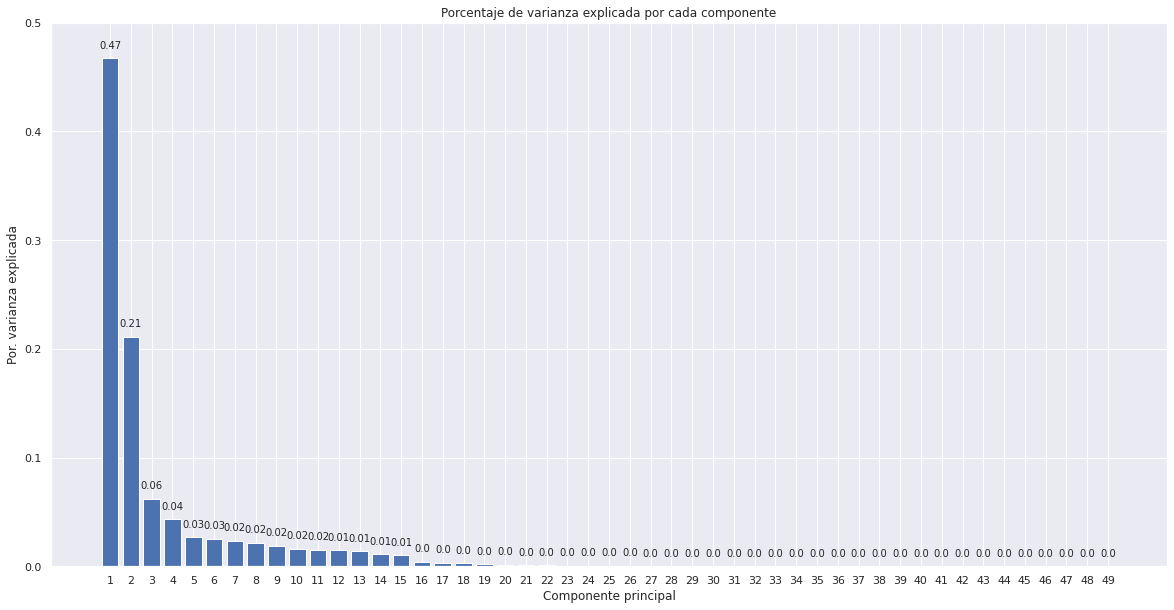

In [ ]:
# Porcentaje de varianza explicada por cada componente

print('----------------------------------------------------')
print('Porcentaje de varianza explicada por cada componente')
print('----------------------------------------------------')
print(modelo_pca.explained_variance_ratio_)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
ax.bar(
    x      = np.arange(modelo_pca.n_components_) + 1,
    height = modelo_pca.explained_variance_ratio_
)

for x, y in zip(np.arange(len(df_pca.columns)) + 1, modelo_pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_ylim(0, 0.5) 
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada');
#La compnenete 1 explica el 47 % de la varianza observada en los datos

------------------------------------------
Porcentaje de varianza explicada acumulada
------------------------------------------
[0.46752912 0.67881866 0.74103514 0.78439898 0.81122245 0.83641383
 0.85979523 0.88134608 0.90006352 0.91622428 0.93144069 0.94638281
 0.96014785 0.97132311 0.98146902 0.98557394 0.98885392 0.99157209
 0.99360621 0.9951189  0.99608282 0.99695062 0.99756252 0.99814369
 0.99863068 0.99897609 0.99924722 0.99948113 0.999616   0.99971089
 0.99977789 0.99982949 0.99987069 0.99989751 0.99992148 0.99993701
 0.99994929 0.99996013 0.99996939 0.99997652 0.99998206 0.99998709
 0.99999105 0.99999363 0.99999605 0.99999726 0.99999839 0.99999935
 1.        ]


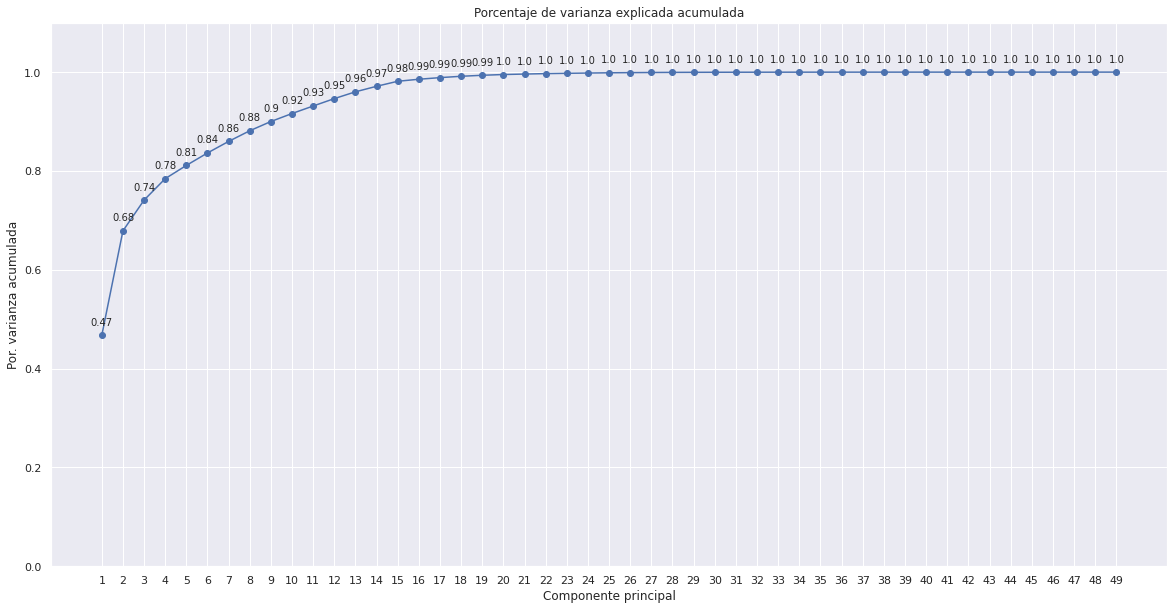

In [ ]:
# Porcentaje de varianza explicada acumulada
# ==============================================================================
prop_varianza_acum = modelo_pca.explained_variance_ratio_.cumsum()
print('------------------------------------------')
print('Porcentaje de varianza explicada acumulada')
print('------------------------------------------')
print(prop_varianza_acum)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
ax.plot(
    np.arange(len(df_pca.columns)) + 1,
    prop_varianza_acum,
    marker = 'o'
)

for x, y in zip(np.arange(len(df_pca.columns)) + 1, prop_varianza_acum):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )
    
ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada');
#Empleando las componenetes 1-15 se explicaría el 99 % de la varianza observada

In [ ]:
# Proyección de las observaciones de entrenamiento (reducir la dimensionalidad de nuevas observaciones proyectándolas en el espacio definido por las componentes)

proyecciones = pca_pipe.transform(X=df_pca)
proyecciones = pd.DataFrame(
    proyecciones,
    columns = ['PC0','PC1', 'PC2', 'PC3','PC4', 'PC5', 'PC6','PC7', 'PC8', 'PC9','PC9', 'PC11', 'PC12','PC13', 'PC14', 'PC15','PC16', 'PC17', 'PC18','PC19', 'PC20', 
              'PC21', 'PC22', 'PC23','PC24', 'PC25', 'PC26','PC27', 'PC28', 'PC29','PC30', 'PC31', 'PC32','PC33', 'PC34', 'PC35','P316', 'PC37', 'PC38','PC39', 'PC40',
               'PC41', 'PC42', 'PC43','PC44', 'PC45', 'PC46','PC47', 'PC48'],
    index   = df_pca.index)
proyecciones.head()

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC9,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,P316,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48
0,3.423529,2.923873,0.189944,0.622219,-1.692802,1.327731,0.789671,1.210574,-0.538181,-1.003129,0.125285,-0.051323,-0.285848,0.563183,1.028568,-0.421536,0.066147,-0.454567,-0.606034,-0.041367,0.196142,0.158207,0.162390,0.123847,-0.242898,0.043418,0.230262,0.092439,0.052383,-0.041027,-0.106243,0.019245,-0.025724,-0.039672,-0.038974,0.020166,-0.035527,0.015393,0.004125,-0.035030,0.003572,0.009063,0.019263,-0.005643,0.009310,-0.002325,-0.017693,0.012688,0.000109
1,1.922723,0.710912,-0.916041,1.304719,0.517387,-1.938079,0.078856,-0.913180,0.159477,0.707811,0.943290,-0.451242,-1.050049,0.607918,0.286012,0.070930,-0.099251,-0.244893,0.075571,0.156889,-0.342858,0.053084,0.024848,0.142120,-0.142471,-0.084591,-0.078036,-0.061183,0.068360,0.051710,0.013697,0.013342,-0.003851,0.031496,-0.000935,0.008455,0.004300,0.010417,-0.008032,-0.001983,-0.005458,0.011361,-0.003000,0.002556,-0.006135,0.001381,0.004886,-0.003827,-0.001728
2,-0.613045,1.503340,-0.806676,-0.383764,-0.752684,-0.298975,0.508245,0.301785,-0.081432,-0.388165,0.517902,-0.224082,-0.535097,0.529321,-0.021656,-0.730156,0.127960,-0.035980,-0.199459,0.134795,-0.056932,-0.008446,0.053382,-0.064149,-0.135780,0.004988,0.005039,-0.112668,0.101193,-0.107557,-0.041393,0.039916,0.011359,0.009274,-0.006823,0.028081,-0.016295,0.018784,0.019403,0.014735,-0.005469,-0.016873,0.028489,0.003116,-0.005495,-0.003580,-0.004073,0.001668,-0.000128
3,-6.454525,5.246218,-0.046663,-0.490552,-1.310366,0.691763,0.367185,0.877055,-0.368954,0.085618,-0.173240,0.278102,0.070369,0.875058,0.179829,-0.045343,-0.223052,0.330498,-0.256442,0.070809,-0.653487,-0.111932,-0.213890,0.024571,0.274864,0.038448,0.032816,-0.020443,-0.043192,0.008147,-0.018041,0.034492,-0.081441,0.031778,-0.004486,-0.026898,0.032840,-0.004216,0.008141,0.005754,-0.006077,-0.008452,-0.014701,0.022319,0.008420,0.010299,0.000427,0.000431,-0.011729
4,-1.740973,-4.405511,-0.258545,-0.788395,0.496036,-0.031093,-0.589189,0.640867,0.044589,-0.228752,0.130822,-0.297632,-0.013316,-1.180946,0.210711,0.017703,-0.235033,0.324324,0.091996,0.028858,0.090268,0.057733,-0.157316,0.052325,0.091751,-0.066877,0.041791,0.030541,0.016086,0.003318,0.034884,-0.059654,0.000798,-0.004866,0.009596,0.003353,0.004540,-0.011232,0.001036,0.006244,0.002793,0.002949,-0.008018,-0.009172,0.012629,-0.000385,0.004439,0.002363,0.003828


In [ ]:
#La transformación es el resultado de multiplicar los vectores que definen cada componente con el valor de las variables. 
#Cálculo de forma manual:
proyecciones = np.dot(modelo_pca.components_, scale(df_pca).T)
proyecciones = pd.DataFrame(proyecciones, index = ['PC0','PC1', 'PC2', 'PC3','PC4', 'PC5', 'PC6','PC7', 'PC8', 'PC9','PC9', 'PC11', 'PC12','PC13', 'PC14', 'PC15','PC16', 'PC17', 'PC18','PC19', 'PC20', 
                'PC21', 'PC22', 'PC23','PC24', 'PC25', 'PC26','PC27', 'PC28', 'PC29','PC30', 'PC31', 'PC32','PC33', 'PC34', 'PC35','P316', 'PC37', 'PC38','PC39', 'PC40',
               'PC41', 'PC42', 'PC43','PC44', 'PC45', 'PC46','PC47', 'PC48'])
proyecciones = proyecciones.transpose().set_index(df_pca.index)
proyecciones.head()

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC9,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,P316,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48
0,3.423529,2.923873,0.189944,0.622219,-1.692802,1.327731,0.789671,1.210574,-0.538181,-1.003129,0.125285,-0.051323,-0.285848,0.563183,1.028568,-0.421536,0.066147,-0.454567,-0.606034,-0.041367,0.196142,0.158207,0.162390,0.123847,-0.242898,0.043418,0.230262,0.092439,0.052383,-0.041027,-0.106243,0.019245,-0.025724,-0.039672,-0.038974,0.020166,-0.035527,0.015393,0.004125,-0.035030,0.003572,0.009063,0.019263,-0.005643,0.009310,-0.002325,-0.017693,0.012688,0.000109
1,1.922723,0.710912,-0.916041,1.304719,0.517387,-1.938079,0.078856,-0.913180,0.159477,0.707811,0.943290,-0.451242,-1.050049,0.607918,0.286012,0.070930,-0.099251,-0.244893,0.075571,0.156889,-0.342858,0.053084,0.024848,0.142120,-0.142471,-0.084591,-0.078036,-0.061183,0.068360,0.051710,0.013697,0.013342,-0.003851,0.031496,-0.000935,0.008455,0.004300,0.010417,-0.008032,-0.001983,-0.005458,0.011361,-0.003000,0.002556,-0.006135,0.001381,0.004886,-0.003827,-0.001728
2,-0.613045,1.503340,-0.806676,-0.383764,-0.752684,-0.298975,0.508245,0.301785,-0.081432,-0.388165,0.517902,-0.224082,-0.535097,0.529321,-0.021656,-0.730156,0.127960,-0.035980,-0.199459,0.134795,-0.056932,-0.008446,0.053382,-0.064149,-0.135780,0.004988,0.005039,-0.112668,0.101193,-0.107557,-0.041393,0.039916,0.011359,0.009274,-0.006823,0.028081,-0.016295,0.018784,0.019403,0.014735,-0.005469,-0.016873,0.028489,0.003116,-0.005495,-0.003580,-0.004073,0.001668,-0.000128
3,-6.454525,5.246218,-0.046663,-0.490552,-1.310366,0.691763,0.367185,0.877055,-0.368954,0.085618,-0.173240,0.278102,0.070369,0.875058,0.179829,-0.045343,-0.223052,0.330498,-0.256442,0.070809,-0.653487,-0.111932,-0.213890,0.024571,0.274864,0.038448,0.032816,-0.020443,-0.043192,0.008147,-0.018041,0.034492,-0.081441,0.031778,-0.004486,-0.026898,0.032840,-0.004216,0.008141,0.005754,-0.006077,-0.008452,-0.014701,0.022319,0.008420,0.010299,0.000427,0.000431,-0.011729
4,-1.740973,-4.405511,-0.258545,-0.788395,0.496036,-0.031093,-0.589189,0.640867,0.044589,-0.228752,0.130822,-0.297632,-0.013316,-1.180946,0.210711,0.017703,-0.235033,0.324324,0.091996,0.028858,0.090268,0.057733,-0.157316,0.052325,0.091751,-0.066877,0.041791,0.030541,0.016086,0.003318,0.034884,-0.059654,0.000798,-0.004866,0.009596,0.003353,0.004540,-0.011232,0.001036,0.006244,0.002793,0.002949,-0.008018,-0.009172,0.012629,-0.000385,0.004439,0.002363,0.003828


In [ ]:
# Recostruccion de las proyecciones (revertir la proyección)

recostruccion = pca_pipe.inverse_transform(proyecciones)
recostruccion = pd.DataFrame(
                    recostruccion,
                    columns = df_pca.columns,
                    index   = df_pca.index
)
print('------------------')
print('Valores reconstruidos')
print('------------------')
display(recostruccion.head())

print('---------------------')
print('Valores originales')
print('---------------------')
display(df_pca.head())

------------------
Valores reconstruidos
------------------


,Q_R_4_0_0,Q_R_4_0_1,Q_R_4_0_2,Q_R_4_0_3,Q_R_4_0_4,Q_R_4_0_5,Q_R_4_0_6,Q_R_4_0_7,Q_R_4_0_8,Q_R_4_0_9,Q_R_4_1_0,Q_G_3_0_0,Q_G_3_0_1,Q_G_3_0_2,Q_G_3_0_3,Q_G_3_0_4,Q_G_3_0_5,Q_G_3_0_6,Q_G_3_0_7,Q_G_3_0_8,Q_G_3_0_9,Q_G_3_1_0,Q_B_2_0_0,Q_B_2_0_1,Q_B_2_0_2,Q_B_2_0_3,Q_B_2_0_4,Q_B_2_0_5,Q_B_2_0_6,Q_B_2_0_7,Q_B_2_0_8,Q_B_2_0_9,Q_B_2_1_0,Q_NIR_8_0_0,Q_NIR_8_0_1,Q_NIR_8_0_2,Q_NIR_8_0_3,Q_NIR_8_0_4,Q_NIR_8_0_5,Q_NIR_8_0_6,Q_NIR_8_0_7,Q_NIR_8_0_8,Q_NIR_8_0_9,Q_NIR_8_1_0,AREA,CONTRUCTIONYEAR,MAXBUILDINGFLOOR,CADASTRALQUALITYID,CLASE
0,3.388132e-20,443.001300,616.001697,746.998401,872.996472,1009.000946,1159.002319,1342.002466,1572.003418,1943.686816,6512.787270,1.283357e-10,428.996347,574.000940,676.002960,778.003931,880.999176,997.000220,1130.001782,1311.997949,1626.996155,8627.098641,155.003632,402.000092,458.999939,510.000061,567.999939,632.000610,681.000916,726.109186,791.000269,902.999719,1980.172280,1.342890e-05,892.016479,1244.014185,1497.998303,1731.204688,1944.003906,2160.996533,2410.995264,2719.999756,3180.000342,10951.926645,144.426900,2002.0,-3.108624e-15,1.0,5.0
1,5.879611e-05,443.899011,627.999060,770.001611,904.999988,1032.998474,1165.001636,1316.000110,1505.990771,1804.993469,6269.935600,1.352495e-11,433.998392,565.000110,662.996521,746.001318,828.998413,912.000330,1011.997162,1142.202637,1384.994580,5357.790999,120.000275,419.000000,472.999939,509.999808,541.999976,572.000000,602.999939,636.000122,673.000122,745.000000,3647.195402,2.967464e-05,846.002728,1139.006982,1363.993860,1558.000513,1749.993713,1956.000464,2194.001978,2507.001416,3012.991675,7048.367637,38.342550,1949.0,1.000000e+00,7.0,5.0
2,-4.065758e-20,353.502274,523.003601,644.001831,760.997131,876.999634,1006.997498,1168.995544,1375.008179,1719.003235,5010.767611,2.385245e-18,379.001587,507.003815,600.000519,684.000488,768.997528,867.001587,992.991760,1165.998413,1443.000366,5240.232771,83.000389,363.000031,429.002502,473.000015,510.000092,549.000244,590.999939,635.999817,692.999817,796.498779,1947.739721,5.158229e-06,807.001373,1124.002441,1365.009583,1570.995117,1768.992798,1978.989258,2228.999146,2561.999756,3088.000488,7013.073271,108.794384,1986.0,1.000000e+00,4.0,5.0
3,-3.252607e-19,268.000613,376.999609,478.003784,575.001233,683.997742,809.005994,955.002960,1136.997144,1447.997290,5465.430281,6.341585e-06,310.999088,405.998712,485.000607,558.997925,641.001007,731.994189,838.004376,974.797485,1217.996167,5343.168796,0.001450,256.999487,295.999969,329.000092,366.000043,411.000549,457.000061,506.000000,565.999817,663.999817,1424.396092,2.284635e-03,1200.994470,1476.001294,1678.005042,1848.001782,2022.988464,2211.993506,2433.003687,2740.996582,3349.986328,6216.880538,155.224455,1999.0,1.000000e+00,1.0,5.0
4,-3.388132e-20,318.997910,492.003845,632.999634,757.002197,882.999908,1019.008911,1175.993103,1401.000488,1756.994141,7376.529218,4.163336e-16,284.000534,421.002472,526.003815,618.998779,705.999268,801.005432,912.999451,1069.996094,1348.497314,7460.394534,193.000626,431.505035,462.999939,492.000061,519.000427,547.000061,578.999878,617.999603,662.999939,750.000488,1940.403140,-1.110223e-15,529.004425,790.996704,999.001617,1183.995239,1355.992920,1535.998779,1725.498962,1954.991455,2315.991455,7092.767616,1789.873366,1966.0,8.000000e+00,5.0,5.0


---------------------
Valores originales
---------------------


,Q_R_4_0_0,Q_R_4_0_1,Q_R_4_0_2,Q_R_4_0_3,Q_R_4_0_4,Q_R_4_0_5,Q_R_4_0_6,Q_R_4_0_7,Q_R_4_0_8,Q_R_4_0_9,Q_R_4_1_0,Q_G_3_0_0,Q_G_3_0_1,Q_G_3_0_2,Q_G_3_0_3,Q_G_3_0_4,Q_G_3_0_5,Q_G_3_0_6,Q_G_3_0_7,Q_G_3_0_8,Q_G_3_0_9,Q_G_3_1_0,Q_B_2_0_0,Q_B_2_0_1,Q_B_2_0_2,Q_B_2_0_3,Q_B_2_0_4,Q_B_2_0_5,Q_B_2_0_6,Q_B_2_0_7,Q_B_2_0_8,Q_B_2_0_9,Q_B_2_1_0,Q_NIR_8_0_0,Q_NIR_8_0_1,Q_NIR_8_0_2,Q_NIR_8_0_3,Q_NIR_8_0_4,Q_NIR_8_0_5,Q_NIR_8_0_6,Q_NIR_8_0_7,Q_NIR_8_0_8,Q_NIR_8_0_9,Q_NIR_8_1_0,AREA,CONTRUCTIONYEAR,MAXBUILDINGFLOOR,CADASTRALQUALITYID,CLASE
0,0.000000,443.001300,616.001697,746.998401,872.996472,1009.000946,1159.002319,1342.002466,1572.003418,1943.686816,6512.787270,1.283357e-10,428.996347,574.000940,676.002960,778.003931,880.999176,997.000220,1130.001782,1311.997949,1626.996155,8627.098641,155.003632,402.000092,458.999939,510.000061,567.999939,632.000610,681.000916,726.109186,791.000269,902.999719,1980.172280,0.000013,892.016479,1244.014185,1497.998303,1731.204688,1944.003906,2160.996533,2410.995264,2719.999756,3180.000342,10951.926645,144.426900,2002.0,0.0,1,5
1,0.000059,443.899011,627.999060,770.001611,904.999988,1032.998474,1165.001636,1316.000110,1505.990771,1804.993469,6269.935600,1.352518e-11,433.998392,565.000110,662.996521,746.001318,828.998413,912.000330,1011.997162,1142.202637,1384.994580,5357.790999,120.000275,419.000000,472.999939,509.999808,541.999976,572.000000,602.999939,636.000122,673.000122,745.000000,3647.195402,0.000030,846.002728,1139.006982,1363.993860,1558.000513,1749.993713,1956.000464,2194.001978,2507.001416,3012.991675,7048.367637,38.342550,1949.0,1.0,7,5
2,0.000000,353.502274,523.003601,644.001831,760.997131,876.999634,1006.997498,1168.995544,1375.008179,1719.003235,5010.767611,0.000000e+00,379.001587,507.003815,600.000519,684.000488,768.997528,867.001587,992.991760,1165.998413,1443.000366,5240.232771,83.000389,363.000031,429.002502,473.000015,510.000092,549.000244,590.999939,635.999817,692.999817,796.498779,1947.739721,0.000005,807.001373,1124.002441,1365.009583,1570.995117,1768.992798,1978.989258,2228.999146,2561.999756,3088.000488,7013.073271,108.794384,1986.0,1.0,4,5
3,0.000000,268.000613,376.999609,478.003784,575.001233,683.997742,809.005994,955.002960,1136.997144,1447.997290,5465.430281,6.341585e-06,310.999088,405.998712,485.000607,558.997925,641.001007,731.994189,838.004376,974.797485,1217.996167,5343.168796,0.001450,256.999487,295.999969,329.000092,366.000043,411.000549,457.000061,506.000000,565.999817,663.999817,1424.396092,0.002285,1200.994470,1476.001294,1678.005042,1848.001782,2022.988464,2211.993506,2433.003687,2740.996582,3349.986328,6216.880538,155.224455,1999.0,1.0,1,5
4,0.000000,318.997910,492.003845,632.999634,757.002197,882.999908,1019.008911,1175.993103,1401.000488,1756.994141,7376.529218,0.000000e+00,284.000534,421.002472,526.003815,618.998779,705.999268,801.005432,912.999451,1069.996094,1348.497314,7460.394534,193.000626,431.505035,462.999939,492.000061,519.000427,547.000061,578.999878,617.999603,662.999939,750.000488,1940.403140,0.000000,529.004425,790.996704,999.001617,1183.995239,1355.992920,1535.998779,1725.498962,1954.991455,2315.991455,7092.767616,1789.873366,1966.0,8.0,5,5


In [ ]:
X_pca = recostruccion.drop(['CLASE'], axis= 1)
y_pca = recostruccion['CLASE']

In [ ]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_pca, y_pca, test_size=0.20)

In [ ]:
#Aplicamos el clasificador Random Forest
clf_pca = RandomForestRegressor()

In [ ]:
#fit(X_train_pca,y_train_pca)
clf_pca.fit(X_train_pca,y_train_pca)

RandomForestRegressor()

In [ ]:
predicted_rf_pca = clf_pca.predict(X_test_pca)
predicted_rf_pca

array([5.  , 4.97, 5.  , ..., 4.88, 5.  , 4.85])

In [ ]:
# Confidence score aplicado al y_test (Random Forest)
rf_score = round(clf_pca.score(X_train_pca,y_train_pca) * 100, 2)

print(rf_score)

92.16


In [115]:
# Confidence score aplicado al y_test (Random Forest)
rf_score = round(clf_pca.score(X_test_pca,y_test_pca) * 100, 2)

print(rf_score)

46.37


PCA utilizando sólo 15 componentes principales

In [91]:
# Proyección de 49 a 15 componentes principales
pca_3 = PCA(15)  
projected = pca_3.fit_transform(df_pca)
print(df_pca.shape)
print(projected.shape)

(36392, 49)
(36392, 15)


In [96]:
recostruccion_2 = pca_3.inverse_transform(projected)
recostruccion_2 = pd.DataFrame(
                    recostruccion,
                    columns = df_pca.columns,
                    index   = df_pca.index
)

In [99]:
X_pca_15 = recostruccion_2.drop(['CLASE'], axis= 1)
y_pca_15 = recostruccion_2['CLASE']

In [100]:
X_train_pca_15, X_test_pca_15, y_train_pca_15, y_test_pca_15 = train_test_split(
    X_pca_15, y_pca_15, test_size=0.20)

In [101]:
#Aplicamos el clasificador Random Forest
clf_pca_15 = RandomForestRegressor()

In [102]:
#fit(X_train_pca,y_train_pca)
clf_pca_15.fit(X_train_pca_15,y_train_pca_15)

RandomForestRegressor()

In [103]:
predicted_rf_pca = clf_pca.predict(X_test_pca)
predicted_rf_pca

array([5.  , 4.97, 5.  , ..., 4.88, 5.  , 4.85])

In [104]:
# Confidence score aplicado al y_test (Random Forest)
rf_score = round(clf_pca_15.score(X_train_pca_15,y_train_pca_15) * 100, 2)

print(rf_score)

99.62


In [116]:
# Confidence score aplicado al y_test (Random Forest)
rf_score = round(clf_pca_15.score(X_test_pca,y_test_pca) * 100, 2)

print(rf_score)

9.75


----------------------------------------------------
Porcentaje de varianza explicada por cada componente
----------------------------------------------------
[7.94432021e-01 9.48622704e-02 3.71198682e-02 2.90182727e-02
 1.90185367e-02 1.38504612e-02 8.11248785e-03 1.52511495e-03
 1.17921397e-03 3.13789609e-04 1.44899853e-04 1.03421057e-04
 8.33735592e-05 5.86470698e-05 4.59232256e-05]


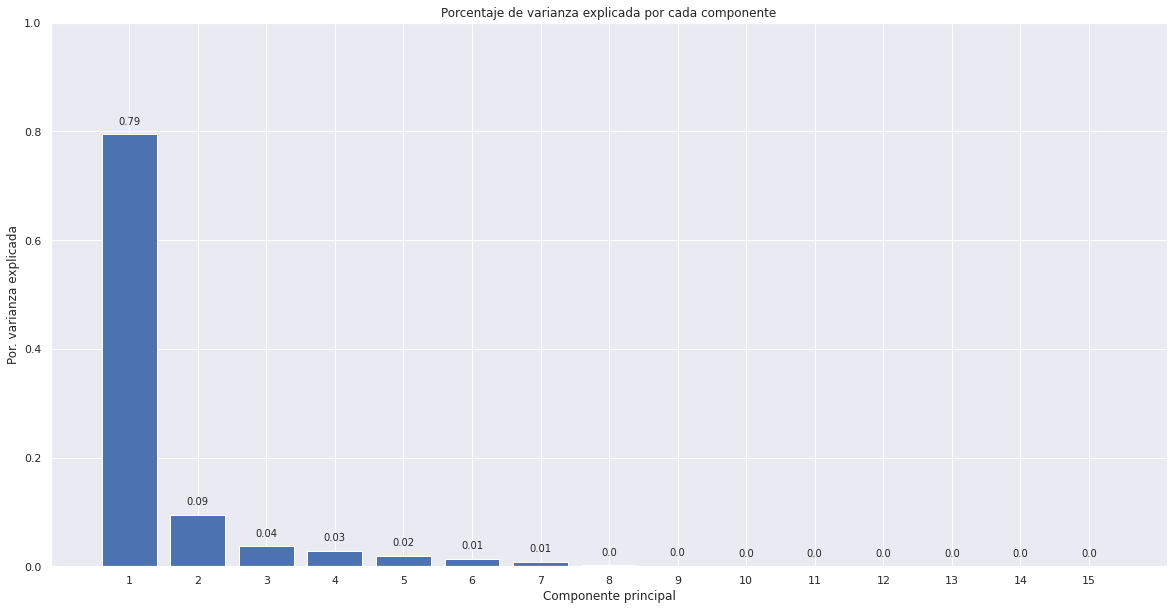

In [108]:
# Porcentaje de varianza explicada por cada componente (se utilizan 15 componentes en este caso)

print('----------------------------------------------------')
print('Porcentaje de varianza explicada por cada componente')
print('----------------------------------------------------')
print(pca_3.explained_variance_ratio_)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
ax.bar(
    x      = np.arange(pca_3.n_components_) + 1,
    height = pca_3.explained_variance_ratio_
)

for x, y in zip(np.arange(len(df_pca.columns)) + 1, pca_3.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(pca_3.n_components_) + 1)
ax.set_ylim(0, 1.0) 
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada');
